# Estimating the Parameters of Differential Equations using Turing.jl

## Load packages

In [1]:
using DifferentialEquations
using ParameterizedFunctions
using RecursiveArrayTools
using Turing
using PyCall, PyPlot; pygui(:tk); plt["style"]["use"]("ggplot")

## Define function for DE

In [2]:
f = @ode_def_nohes LotkaVolterraTest begin
    dx = a*x - b*x*y
    dy = -c*y + d*x*y
end a=>1.5 b=1.0 c=3.0 d=1.0

(::LotkaVolterraTest) (generic function with 14 methods)

In [3]:
u0 = [1.0;1.0]
tspan = (0.0,10.0)
;

## Generate data

In [4]:
prob = ODEProblem(f,u0,tspan)
sol = solve(prob,Tsit5())
t = collect(linspace(0,10,40)) # I reduce the number of data so that I can see error bars from the 2nd prediction way
sig = 0.49  # nosie level
data = convert(Array, VectorOfArray([(sol(t[i]) + sig*randn(2)) for i in 1:length(t)]))
;

In [5]:
function problem_new_parameters(prob::ODEProblem,p)
  f = (t,u,du) -> prob.f(t,u,p,du)
  uEltype = eltype(p)
  u0 = [uEltype(prob.u0[i]) for i in 1:length(prob.u0)]
  tspan = (uEltype(prob.tspan[1]),uEltype(prob.tspan[2]))
  ODEProblem(f,u0,tspan)
end

problem_new_parameters (generic function with 1 method)

## Define a Bayes model to fit parameters

$$ a \sim \text{Truncated}(\text{Normal}(1.5, 1), 0.5, 2.5) $$

$$ \sigma \sim \text{Inverse-Gamma}(2, 3) $$

$$ \text{Compute } sol_a $$

$$ data \sim \text{MvNormal}(sol_a, \sigma I) $$

**Note**: the use of truncated Gaussian for $a$ is just from my trails - I experience some bugs when $a<0$ and when $a$ is large.

In [6]:
@model bfit(x) = begin
    # Define prior
    a ~ Truncated(Normal(1.5, 1), 0.5, 2.5)  # DE param
    σ ~ InverseGamma(2, 3)               # data noise
    
    # Update solver
    p_tmp = problem_new_parameters(prob, a); sol_tmp = solve(p_tmp,Tsit5())
    
    # Observe data
    # Here you can do a lot of ways to write the observation
    # and a lot of possible optimization to make the program faster
    # E.g. naively
    
    for i = 1:length(t)
        res = sol_tmp(t[i])
        x[:,i] ~ MvNormal(res, σ*ones(2))
    end
end

bfit (generic function with 2 methods)

## Run sampler

In [7]:
chn = sample(bfit(data), HMC(400, 0.02, 4))

[Turing]:  Assume - `a` is a parameter
  in @~(::Any, ::Any) at compiler.jl:76
[Turing]:  Assume - `σ` is a parameter
  in @~(::Any, ::Any) at compiler.jl:76
[Turing]:  Observe - `x` is an observation
  in @~(::Any, ::Any) at compiler.jl:57


[HMC] Sampling...  0%  ETA: 1:20:45
  ϵ:         0.02
  α:         0.9841592573461948
[HMC] Sampling... 32%  ETA: 0:00:23[A
  ϵ:         0.02
  α:         1.0
[HMC] Sampling... 61%  ETA: 0:00:07[A
  ϵ:         0.02
  α:         1.7059286893938555e-92
[HMC] Sampling... 92%  ETA: 0:00:01[A
  ϵ:         0.02
  α:         6.449470243483283e-58
  pre_cond:  [1.0,1.0]

[HMC] Finished with
  Running time        = 12.919197283000004;
  Accept rate         = 0.126;
  #lf / sample        = 4.99;
  #evals / sample     = 4.994;
  pre-cond. diag mat  = [1.0,1.0].


[HMC] Sampling...100% Time: 0:00:13


Object of type "Turing.Chain"

Iterations = 1:500
Thinning interval = 1
Chains = 1
Samples per chain = 500

[-204.312 0.0 … 3.02462 2.03646; -200.831 5.0 … 2.82618 1.98944; … ; -49.6222 5.0 … 0.418735 1.50132; -49.6222 5.0 … 0.418735 1.50132]

## Make prediction 1: averaging samples as point estimate

In [8]:
a_avg = mean(chn[:a])
σ_avg = mean(chn[:σ])
println("E[a] = $a_avg, E[σ] = $σ_avg")
println("a.diff = $(a_avg - 1.5), σ.diff = $(σ_avg - 0.49)")

E[a] = 1.5057466164403581, E[σ] = 0.47625122811472226
a.diff = 0.005746616440358121, σ.diff = -0.013748771885277733


In [9]:
tp = collect(linspace(0,10,200)) # t for plot
;

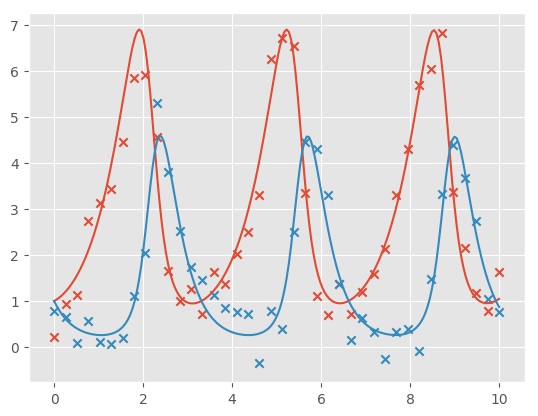

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3258fd9d0>

In [10]:
p_avg = problem_new_parameters(prob, a_avg); sol_avg = solve(p_avg,Tsit5())
pred_avg = convert(Array, VectorOfArray([sol_avg(tp[i]) for i in 1:length(tp)]))
scatter(t, data[1,:] ,marker="x")
scatter(t, data[2,:] ,marker="x")
plot(tp, pred_avg[1,:])
plot(tp, pred_avg[2,:])

## Make prediction 2: the Bayesian way

In [11]:
all_a = chn[:a]
p1 = []
p2 = []
for i = 1:10:length(all_a)    # not taking each sample as that's too expensive
    p_bayes = problem_new_parameters(prob, all_a[i]); sol_bayes = solve(p_bayes,Tsit5())
    pred_bayes = convert(Array, VectorOfArray([sol_avg(tp[i]) for i in 1:length(tp)]))
    push!(p1, pred_bayes[1,:])
    push!(p2, pred_bayes[2,:])
end
p1 = convert(Array,VectorOfArray(p1))
p2 = convert(Array,VectorOfArray(p2))
p1 = Array{Float64,2}(p1)
p2 = Array{Float64,2}(p2)
;

### Compute mean and 3 std error bar

In [12]:
m1 = vec(mean(p1, 2))
m2 = vec(mean(p2, 2))
e1 = 3*vec(sqrt(var(p1,2)))
e2 = 3*vec(sqrt(var(p2,2)))
;

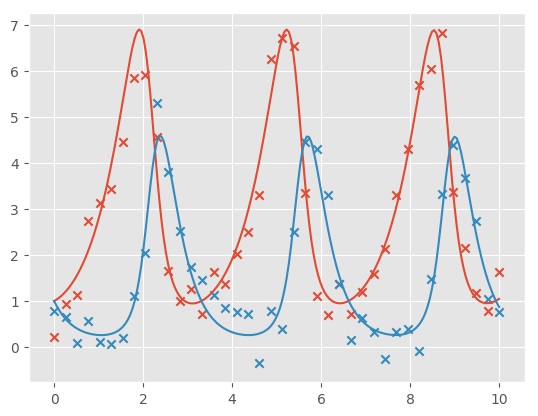

PyObject <matplotlib.collections.PolyCollection object at 0x327e23510>

In [13]:
scatter(t, data[1,:] ,marker="x")
scatter(t, data[2,:] ,marker="x")
plot(tp, m1)
fill_between(tp, m1-e1, m1+e1)
plot(tp, m2)
fill_between(tp, m2-e2, m2+e2)

**Note**: the prediction variance seems to be very small; can't even see from the plot